In [1]:
# 모델 예측값 보정하기

In [2]:
library(ggplot2)
library(dplyr)


Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



데이터 분석을 하다 보면, 내가 모델을 만들기도 하지만, 다른 곳에서 만든 모델의 결과값을 사용해야 할 때도 있다. 남이 만든 모델을 잘 활용하기 위해서는 그 모델이 내놓은 예측값 (점수일 수도 있고 확률일 수도 있고) 의 의미를 파악하고, 필요하면 보정을 해야 한다. 이 보정하는 작업을 캘리브레이션이라고 한다.

쉽게 말해서, 어떤 분류기가 1점 만점의 점수를 내놓는다고 했을 때, 0.8점 받은 케이스를 100개 뜯어보면 실제로 80개가 맞아야 한다. 그래야 믿고 쓸 수 있다. 당연한 것 같지만 [Probability calibration](https://jmetzen.github.io/2015-04-14/calibration.html)에서 Logistic Regression, Naive Bayes, Support Vector Machine의 Reliability Diagram을 보면, 모델의 성격에 따라서 예측값의 분포나 점수대 별 정확도가 차이남을 알 수 있다. 또, 경우에 따라서는 모델 예측값이 만점일 때에도 정확도가 100%에 못 미칠 수 있다. 이런 다양한 상황에서 믿을 만하게 캘리브레이션하는 방법이 필요하다.

[Classifier calibration with Platt's scaling and isotonic regression](http://fastml.com/classifier-calibration-with-platts-scaling-and-isotonic-regression)에 따르면, 예측값을 보정하는 방법에는 크게 두 가지가 있다. Platt’s Scaling과 Isotonic Regression이다.

### Platt’s Scaling

Platt’s Scaling은 모델의 결과값을 다시 한 번 Logistic Regression에 태워서 값을 보정하는 것이다. 이 방식에는 보정 함수의 형태가 시그모이드라는 가정이 깔려 있다. 시그모이드 함수의 모양은 아래와 같고, 파라미터를 통해서 더 세우거나 눕힐 수 있지만 그렇다고 해서 모든 모양을 만들 수는 없다.

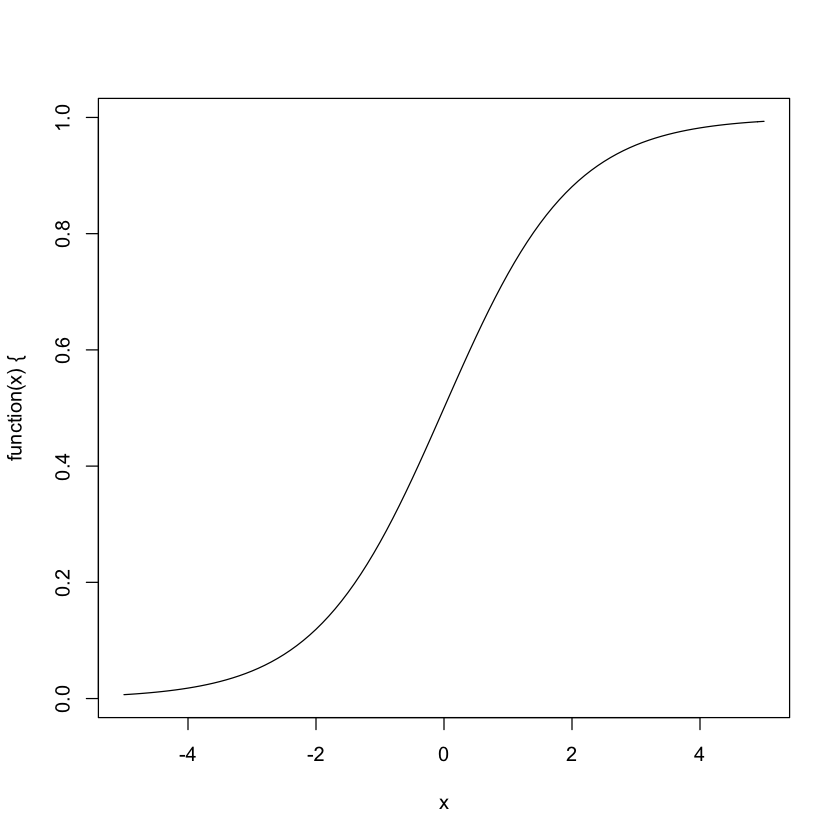

In [3]:
# sigmoid
plot(function(x) { 1 / (1 + exp(-x)) }, xlim=c(-5, 5))

### Isotonic Regression

Isotonic Regression에 대해서는 [위키피디아](https://en.wikipedia.org/wiki/Isotonic_regression)에 나오는 그림이 제일 쉽고 빠르게 설명해준다.

파란색 점들이 입력으로 주어졌을 때, 오차를 작게 하면서 비감소하는 (계단 모양의 빨간선처럼 값이 오른쪽으로 갈수록 적어도 작아지지는 않는) 함수를 찾아준다. Non-parametric한 방식이기 때문에 Platt’s Scaling에서와 같은 가정이 없고 함수 형태가 더 자유롭다.

Platt’s Scaling과 Istonic Regression을 비교하기 위해 극단적이고 작위적인 데이터를 한 번 만들어봤다.

In [4]:
x1 <- runif(10, 0, 0.3)
y1 <- runif(10, 0, 0.1)

x2 <- runif(100, 0.3, 1.0)
y2 <- runif(100, 0.4, 0.6)

d <- data.frame(c(x1, x2), c(y1, y2))
names(d) <- c('x', 'y')

Warning message:
In eval(expr, envir, enclos): non-integer counts in a binomial glm!

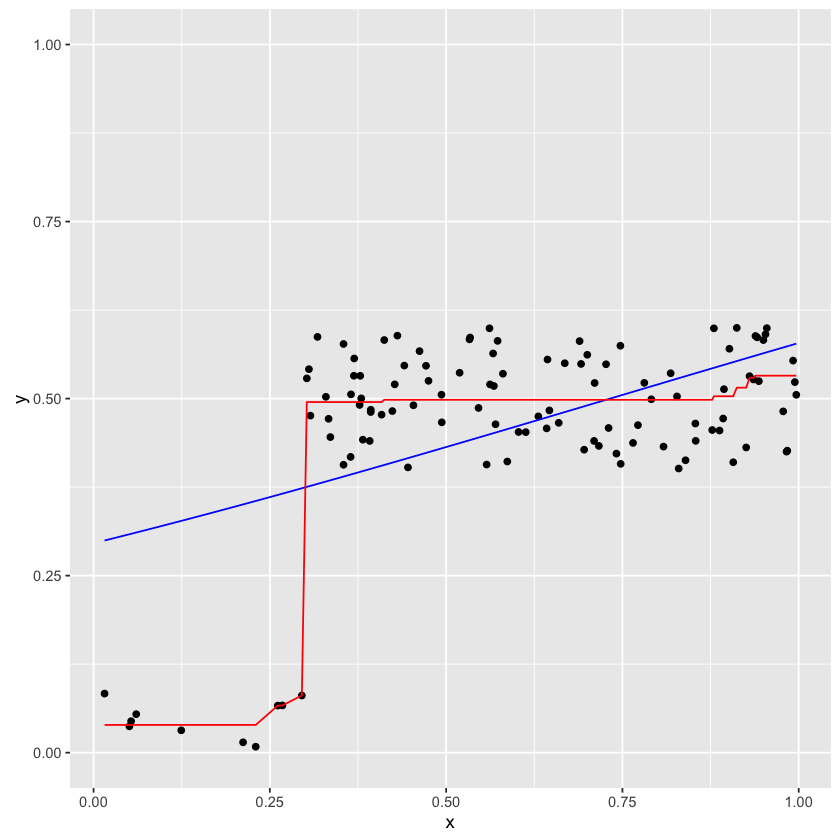

In [5]:
d2 <- d %>% arrange(x)

# 1. Logistic Regression (Platt's scaling)
m_lgst <- glm(cbind(100*y, 100*(1-y)) ~ x, data=d2, family='binomial')
m0_lgst <- m_lgst$coef[1]
m1_lgst <- m_lgst$coef[2]

# 2. Isotonic Regression
m_isotonic <- isoreg(d2$x, d2$y)

d2 <- d2 %>% mutate(yf = m_isotonic$yf)

ggplot(d2) +
    geom_jitter(aes(x, y)) +
#    stat_smooth(aes(x, y)) + 
    stat_function(fun=function(x) {1 / (1 + exp(0 - (m0_lgst + m1_lgst*x)))}, colour='blue') + # Platt's Scaling
    geom_line(aes(x, yf), colour='red') + # Isotonic Regression
    ylim(0, 1) #+ xlim(-2, 2)

파란선이 Platt’s Scaling 즉 Logistic Regression이고, 빨간선이 Isotonic Regression이다. 파란선이 직선처럼 보이지만 x축의 범위를 좀더 넓혀보면 시그모이드 형태를 확인할 수 있다.

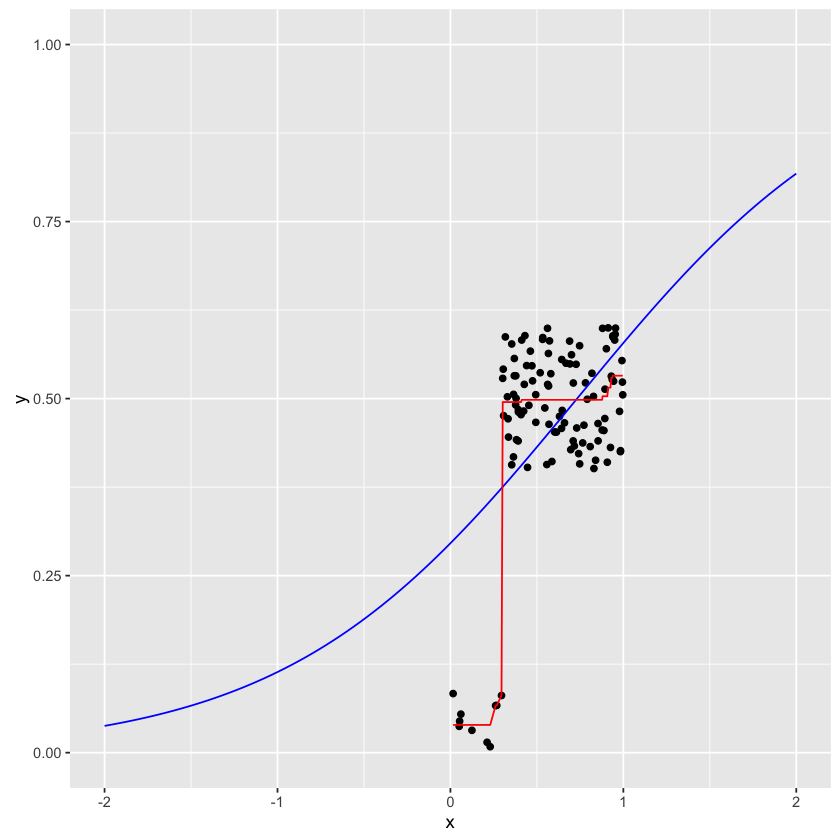

In [6]:
ggplot(d2) +
    geom_jitter(aes(x, y)) +
#    stat_smooth(aes(x, y)) + 
    stat_function(fun=function(x) {1 / (1 + exp(0 - (m0_lgst + m1_lgst*x)))}, colour='blue') + # Platt's Scaling
    geom_line(aes(x, yf), colour='red') + # Isotonic Regression
    ylim(0, 1) + xlim(-2, 2)

### 참고자료

- https://jmetzen.github.io/2015-04-14/calibration.html
- http://fastml.com/classifier-calibration-with-platts-scaling-and-isotonic-regression/
- https://www.quora.com/How-is-isotonic-regression-used-in-practice-for-calibration-in-machine-learning
- http://stat.wikia.com/wiki/Isotonic_regression